# Telco Customer Churn with ANN

**Problem**: Development of a deep learning model that can predict customers who are likely to churn is required.

The Telco customer churn data contains information about 7043 customers who were provided with home telephone and Internet services by a telecom company in California during a specific quarter of a given year.

**21 Variables, 7043 Observations**

Each row represents a unique customer.
Variables include information about the services customers are subscribed to, details about their accounts, contracts, etc.

In [3]:
#  !pip install keras-tuner
import keras
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
from joblib import dump, load

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Activation
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import ReLU, LeakyReLU, PReLU
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters


random.seed(46)
np.random.seed(46)
tf.random.set_seed(46)

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Useful Customized Functions

In [5]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"] # categorical columns

    num_but_cat = [col for col in dataframe.columns if
                   dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    # numerical but seems categoric columns

    # cat_but_car => cardinal columns
    cat_but_car = [col for col in dataframe.columns if
                   dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat

    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols => numerical columns
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]

    num_cols = [col for col in num_cols if col not in num_but_cat]

    return cat_cols, num_cols, cat_but_car


def prepare_datasets(X_train, X_val, y_train, y_val, batch_size=None):
    if batch_size is None:
        batch_size = len(X_train)
        
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(batch_size)
    
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    val_dataset = val_dataset.batch(batch_size)
    
    return train_dataset, val_dataset

def plot_training_history(history, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy'):

    #Loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_loss], label='Training Loss')
    plt.plot(history.history[val_loss], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Metrics
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_metric], label=f"Training: {train_metric}")
    plt.plot(history.history[val_metric], label=f"Validation: {val_metric}")
    plt.title(f'Training and Validation {train_metric} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(f'train_metric')
    plt.legend()
    plt.show()

def get_best_epoch_details(history, metric="val_loss", mode=min):
    
    metric_values = history.history[metric]
    min_metric_value_index = metric_values.index(mode(metric_values))
    best_epoch = min_metric_value_index + 1

    metrics = []
    values = []

    for key, value in history.history.items():
        metrics.append(key)
        values.append(value[min_metric_value_index])

    data = {'Metric': metrics, 'Value': values}
    df = pd.DataFrame(data)
    df['Value'] = df['Value'].map('{:.4f}'.format)
    
    best_epoch_data = pd.DataFrame({'Metric': ['best_epoch'], 'Value': [str(best_epoch)]})
    df = pd.concat([df, best_epoch_data], ignore_index=True)
    
    return df

def print_hyperparameters(hyperparameters):
    hp_df = pd.DataFrame(list(hyperparameters.items()), columns=['Hyperparameter', 'Value'])
    print(hp_df)


def dataproprocessing(dataframe):

    cat_cols, num_cols, cat_but_car = grab_col_names(dataframe)

    dataframe["TotalCharges"].fillna(dataframe["TotalCharges"].median(), inplace=True) # The TotalCharges column's missing values has been filled in.

    # FEATURE ENGINEERING PART
    dataframe.loc[(dataframe["tenure"] >= 0) & (dataframe["tenure"] <= 12), "NEW_TENURE_YEAR"] = "0-1 Year"
    dataframe.loc[(dataframe["tenure"] > 12) & (dataframe["tenure"] <= 24), "NEW_TENURE_YEAR"] = "1-2 Year"
    dataframe.loc[(dataframe["tenure"] > 24) & (dataframe["tenure"] <= 36), "NEW_TENURE_YEAR"] = "2-3 Year"
    dataframe.loc[(dataframe["tenure"] > 36) & (dataframe["tenure"] <= 48), "NEW_TENURE_YEAR"] = "3-4 Year"
    dataframe.loc[(dataframe["tenure"] > 48) & (dataframe["tenure"] <= 60), "NEW_TENURE_YEAR"] = "4-5 Year"
    dataframe.loc[(dataframe["tenure"] > 60) & (dataframe["tenure"] <= 72), "NEW_TENURE_YEAR"] = "5-6 Year"

    dataframe["NEW_Engaged"] = dataframe["Contract"].apply(lambda x: 1 if x in ["One year", "Two year"] else 0)

    dataframe["NEW_noProt"] = dataframe.apply(lambda x: 1 if (x["OnlineBackup"] != "Yes") or (x["DeviceProtection"] != "Yes") or (
                x["TechSupport"] != "Yes") else 0, axis=1)

    dataframe["NEW_Young_Not_Engaged"] = dataframe.apply(lambda x: 1 if (x["NEW_Engaged"] == 0) and (x["SeniorCitizen"] == 0) else 0, axis=1)

    dataframe['NEW_TotalServices'] = (dataframe[['PhoneService', 'InternetService', 'OnlineSecurity',
                                  'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                  'StreamingTV', 'StreamingMovies']] == 'Yes').sum(axis=1)

    dataframe["NEW_FLAG_ANY_STREAMING"] = dataframe.apply(
        lambda x: 1 if (x["StreamingTV"] == "Yes") or (x["StreamingMovies"] == "Yes") else 0, axis=1)

    dataframe["NEW_FLAG_AutoPayment"] = dataframe["PaymentMethod"].apply(
        lambda x: 1 if x in ["Bank transfer (automatic)", "Credit card (automatic)"] else 0)

    dataframe["NEW_AVG_Charges"] = dataframe["TotalCharges"] / (dataframe["tenure"] + 1)

    dataframe["NEW_Increase"] = dataframe["NEW_AVG_Charges"] / dataframe["MonthlyCharges"]

    dataframe["NEW_AVG_Service_Fee"] = dataframe["MonthlyCharges"] / (dataframe['NEW_TotalServices'] + 1)

    cat_cols, num_cols, cat_but_car = grab_col_names(dataframe)

    cat_cols.remove("Churn") # Since it was the "target variable", the "churn" column was removed from the categorical variables.

    dataframe = pd.get_dummies(dataframe, columns=cat_cols, drop_first=True, dtype=int) 
    # one-hot encoder has been applied.Thus, the problem was saved from the dummy variable trap.
    
    scaler = MinMaxScaler()

    dataframe[num_cols] = scaler.fit_transform(dataframe[num_cols])

    dump(scaler, 'scaler.joblib') # transformer object has been saved to the local!

    dataframe.columns = [col.replace(' ', '_').upper() for col in dataframe.columns] 
    # Names of Variables (Columns) have been made more understandable!

    y = dataframe["CHURN"]
    X = dataframe.drop(["CHURN", "CUSTOMERID"], axis=1)

    return X, y


## Data Preprocessing

In [6]:
df = pd.read_csv("/content/telco_customer_churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85000,29.85000,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95000,1889.50000,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85000,108.15000,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30000,1840.75000,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70000,151.65000,1


In [7]:
df["Churn"].value_counts() * 100 / len(df)

,count
Churn,
0,73.46301
1,26.53699


In [8]:
X, y = dataproprocessing(df)
X.head()

<ipython-input-5-cbea4358cf4a>:83: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataframe["TotalCharges"].fillna(dataframe["TotalCharges"].median(), inplace=True) # TotalCharges kolunu eksik değerleri dolduruldu.


,TENURE,MONTHLYCHARGES,TOTALCHARGES,NEW_AVG_CHARGES,NEW_INCREASE,NEW_AVG_SERVICE_FEE,GENDER_MALE,PARTNER_YES,DEPENDENTS_YES,PHONESERVICE_YES,MULTIPLELINES_NO_PHONE_SERVICE,MULTIPLELINES_YES,INTERNETSERVICE_FIBER_OPTIC,INTERNETSERVICE_NO,ONLINESECURITY_NO_INTERNET_SERVICE,ONLINESECURITY_YES,ONLINEBACKUP_NO_INTERNET_SERVICE,ONLINEBACKUP_YES,DEVICEPROTECTION_NO_INTERNET_SERVICE,DEVICEPROTECTION_YES,TECHSUPPORT_NO_INTERNET_SERVICE,TECHSUPPORT_YES,STREAMINGTV_NO_INTERNET_SERVICE,STREAMINGTV_YES,STREAMINGMOVIES_NO_INTERNET_SERVICE,STREAMINGMOVIES_YES,CONTRACT_ONE_YEAR,CONTRACT_TWO_YEAR,PAPERLESSBILLING_YES,PAYMENTMETHOD_CREDIT_CARD_(AUTOMATIC),PAYMENTMETHOD_ELECTRONIC_CHECK,PAYMENTMETHOD_MAILED_CHECK,NEW_TENURE_YEAR_1-2_YEAR,NEW_TENURE_YEAR_2-3_YEAR,NEW_TENURE_YEAR_3-4_YEAR,NEW_TENURE_YEAR_4-5_YEAR,NEW_TENURE_YEAR_5-6_YEAR,SENIORCITIZEN_1,NEW_ENGAGED_1,NEW_NOPROT_1,NEW_YOUNG_NOT_ENGAGED_1,NEW_TOTALSERVICES_1,NEW_TOTALSERVICES_2,NEW_TOTALSERVICES_3,NEW_TOTALSERVICES_4,NEW_TOTALSERVICES_5,NEW_TOTALSERVICES_6,NEW_TOTALSERVICES_7,NEW_FLAG_ANY_STREAMING_1,NEW_FLAG_AUTOPAYMENT_1
0,0.01389,0.11542,0.00128,0.00414,0.00041,0.20710,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0
1,0.47222,0.38507,0.21587,0.03227,0.00677,0.18441,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0
2,0.02778,0.35423,0.01031,0.01935,0.00282,0.15883,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0
3,0.62500,0.23930,0.21024,0.02221,0.00674,0.06353,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1
4,0.02778,0.52189,0.01533,0.02980,0.00346,0.88119,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0


In [9]:
X.shape

(7043, 50)

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

train_ds, val_ds = prepare_datasets(X_train, X_val, y_train, y_val, batch_size=32)

## Base Model with Binary LogLoss

In [11]:
X_train.shape[0]

5634

In [12]:
X_val.shape[0]

1409

In [13]:
base_model = Sequential([

    Input(shape=(train_ds.element_spec[0].shape[1],)),
    Dense(50, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')])

optimizer = Adam(learning_rate=0.001)

base_model.compile(optimizer=optimizer,
                   loss="binary_crossentropy", # binary_crossentropy() => logloss function
                   metrics=["accuracy", "precision", "recall", "auc"])

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=20,
                               verbose=1,
                               restore_best_weights=True)

base_model_history = base_model.fit(train_ds,
                                    epochs=1000,
                                    validation_data=val_ds,
                                    verbose=1,
                                    callbacks=early_stopping)

Epoch 1/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5781 - auc: 0.5995 - loss: 0.8961 - precision: 0.3324 - recall: 0.5478 - val_accuracy: 0.7743 - val_auc: 0.8271 - val_loss: 0.5062 - val_precision: 0.6455 - val_recall: 0.3271
Epoch 2/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7420 - auc: 0.7729 - loss: 0.5657 - precision: 0.5251 - recall: 0.5455 - val_accuracy: 0.7935 - val_auc: 0.8448 - val_loss: 0.4640 - val_precision: 0.6708 - val_recall: 0.4316
Epoch 3/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7558 - auc: 0.7885 - loss: 0.5262 - precision: 0.5518 - recall: 0.4808 - val_accuracy: 0.8034 - val_auc: 0.8478 - val_loss: 0.4541 - val_precision: 0.6538 - val_recall: 0.5469
Epoch 4/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7839 - auc: 0.8129 - loss: 0.4931 - precision: 0.5989 - recall: 0.5117 - val_accuracy: 0.8034 - val_auc: 0.8480 - val_loss: 0.4520 - val_precision: 0.6579 - val_recall: 0.5362
Epoch 5/1000
177/177 ━━━

In [14]:
get_best_epoch_details(base_model_history, metric="val_loss", mode=min)

,Metric,Value
0,accuracy,0.8055
1,auc,0.8519
2,loss,0.4233
3,precision,0.6733
4,recall,0.5194
5,val_accuracy,0.8119
6,val_auc,0.8555
7,val_loss,0.4191
8,val_precision,0.6720
9,val_recall,0.5657


In [19]:
val_loss, val_accuracy, val_precision, val_recall, val_auc = base_model.evaluate(val_ds, verbose=0)
f1_score = 2 * (val_precision * val_recall) / (val_precision + val_recall)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation AUC: {val_auc}") #AUC gives the area under ROC curves!
print(f"Validation Precision: {val_precision}") # Our reference point is our predictions!
print(f"Validation Recall: {val_recall}") # Our reference point is actual values!
print(f"Validation F1-Score: {f1_score}") # It is good to see it around 0.65-0.70.
# In balanced data segment distribution, we look at Accuracy.
# In unbalanced data segment distribution, AUC, Precision, Recall and F1-score values are checked, not Accuracy.
# NOTE: They are important for situations where the cost of false positives is high. Focusing on Recall is important in this regard.
# In Brief; the higher the AUC and F1 the better :))

Validation Loss: 0.41914066672325134
Validation Accuracy: 0.8119233250617981
Validation AUC: 0.8555474877357483
Validation Precision: 0.6719745397567749
Validation Recall: 0.5656836628913879
Validation F1-Score: 0.6142649371305102


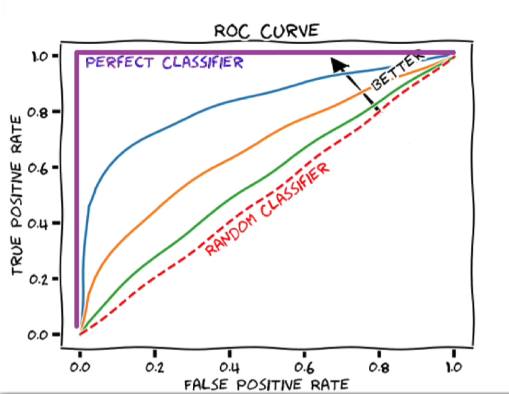

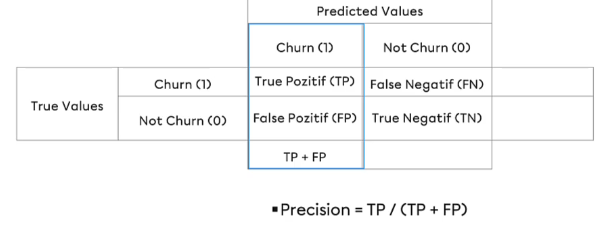

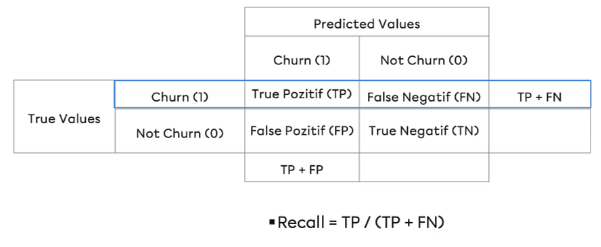

In [16]:
df["Churn"].value_counts() * 100 / len(df)
# From here we can see that the class distribution is unbalanced.

,count
Churn,
0,73.46301
1,26.53699


## Weighted Cross-Entropy Loss

In [20]:
print(len(df[df['Churn'] == 1]),len(df[df['Churn'] == 0]))

1869 5174


In [21]:
# NOTE: It is necessary to express the imbalance of classes to the modeling process!
# These are the ways:
class_weight_for_0 = 1.0 / len(df[df['Churn'] == 0])
class_weight_for_1 = 1.0 / len(df[df['Churn'] == 1])
print(class_weight_for_0, class_weight_for_1)

0.00019327406262079628 0.0005350454788657035


In [22]:
# In fact, we tell the model this words; "Their weights are different. I will give these weights as input.
#  Please take these into consideration in order to avoid bias in the model!" 
# (The model shapes itself in favor of the weight of the larger class.)
class_weights = {0: class_weight_for_0, 1: class_weight_for_1}

base_model = Sequential([
    Input(shape=(train_ds.element_spec[0].shape[1],)),
    Dense(50, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')])

optimizer = Adam(learning_rate=0.001)

base_model.compile(optimizer=optimizer,
                   loss="binary_crossentropy",
                   metrics=["accuracy", "precision", "recall", "auc"])

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=20,
                               verbose=1,
                               restore_best_weights=True,
                               mode='min') # "mode" has been activated, unlike before!

base_model_history = base_model.fit(train_ds,
                                    epochs=1000,
                                    validation_data=val_ds,
                                    verbose=1,
                                    callbacks=early_stopping,
                                    class_weight=class_weights) # class_weight has been activated!

Epoch 1/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5588 - auc: 0.5927 - loss: 0.0318 - precision: 0.3200 - recall: 0.5840 - val_accuracy: 0.6586 - val_auc: 0.8068 - val_loss: 0.6617 - val_precision: 0.4304 - val_recall: 0.8954
Epoch 2/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6940 - auc: 0.7847 - loss: 0.0024 - precision: 0.4575 - recall: 0.7912 - val_accuracy: 0.7942 - val_auc: 0.8402 - val_loss: 0.6027 - val_precision: 0.6084 - val_recall: 0.6247
Epoch 3/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7104 - auc: 0.8026 - loss: 2.4200e-04 - precision: 0.4704 - recall: 0.7828 - val_accuracy: 0.7523 - val_auc: 0.8441 - val_loss: 0.5303 - val_precision: 0.5215 - val_recall: 0.7802
Epoch 4/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7309 - auc: 0.8187 - loss: 1.6057e-04 - precision: 0.4955 - recall: 0.7793 - val_accuracy: 0.7700 - val_auc: 0.8343 - val_loss: 0.4771 - val_precision: 0.5551 - val_recall: 0.6622
Epoch 5/1000
177

In [23]:
get_best_epoch_details(base_model_history, metric="val_loss", mode=min)

,Metric,Value
0,accuracy,0.7281
1,auc,0.8150
2,loss,0.0002
3,precision,0.4923
4,recall,0.7741
5,val_accuracy,0.7807
6,val_auc,0.8440
7,val_loss,0.4522
8,val_precision,0.5643
9,val_recall,0.7534


In [24]:
val_loss, val_accuracy, val_precision, val_recall, val_auc = base_model.evaluate(val_ds, verbose=0)
f1_score = 2 * (val_precision * val_recall) / (val_precision + val_recall)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation AUC: {val_auc}")
print(f"Validation Precision: {val_precision}")
print(f"Validation Recall: {val_recall}")
print(f"Validation F1-Score: {f1_score}")

Validation Loss: 0.4522191882133484
Validation Accuracy: 0.7806955575942993
Validation AUC: 0.8440096974372864
Validation Precision: 0.564257025718689
Validation Recall: 0.7533512115478516
Validation F1-Score: 0.6452353619637714


## Weighted Cross-Entropy Loss and Monitoring With AUC

In [25]:
class_weights = {0: class_weight_for_0, 1: class_weight_for_1}

base_model = Sequential([
    Input(shape=(train_ds.element_spec[0].shape[1],)),
    Dense(50, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')])

optimizer = Adam(learning_rate=0.001)

base_model.compile(optimizer=optimizer,
                   loss="binary_crossentropy",
                   metrics=["accuracy", "precision", "recall", "auc"])

early_stopping = EarlyStopping(monitor='val_auc', # Here; changed for val_loss.
                               patience=20,
                               verbose=1,
                               restore_best_weights=True,
                               mode='max') # here; changed for min.

base_model_history = base_model.fit(train_ds,
                                    epochs=1000,
                                    validation_data=val_ds,
                                    verbose=1,
                                    callbacks=early_stopping,
                                    class_weight=class_weights)

Epoch 1/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5127 - auc: 0.5218 - loss: 0.0312 - precision: 0.2877 - recall: 0.5261 - val_accuracy: 0.6480 - val_auc: 0.7873 - val_loss: 0.6691 - val_precision: 0.4172 - val_recall: 0.8311
Epoch 2/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6651 - auc: 0.7552 - loss: 0.0024 - precision: 0.4216 - recall: 0.7505 - val_accuracy: 0.8034 - val_auc: 0.8500 - val_loss: 0.5751 - val_precision: 0.6752 - val_recall: 0.4960
Epoch 3/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7037 - auc: 0.7953 - loss: 2.3891e-04 - precision: 0.4480 - recall: 0.7840 - val_accuracy: 0.8077 - val_auc: 0.8534 - val_loss: 0.5006 - val_precision: 0.6393 - val_recall: 0.6273
Epoch 4/1000
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7312 - auc: 0.8176 - loss: 1.5801e-04 - precision: 0.4781 - recall: 0.7970 - val_accuracy: 0.7644 - val_auc: 0.8489 - val_loss: 0.4896 - val_precision: 0.5367 - val_recall: 0.8043
Epoch 5/1000
177

In [26]:
get_best_epoch_details(base_model_history, metric="val_auc", mode=max)

,Metric,Value
0,accuracy,0.7196
1,auc,0.8039
2,loss,0.0002
3,precision,0.4826
4,recall,0.7781
5,val_accuracy,0.7381
6,val_auc,0.8556
7,val_loss,0.4947
8,val_precision,0.5032
9,val_recall,0.8365


In [27]:
val_loss, val_accuracy, val_precision, val_recall, val_auc = base_model.evaluate(val_ds, verbose=0)
f1_score = 2 * (val_precision * val_recall) / (val_precision + val_recall)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation AUC: {val_auc}")
print(f"Validation Precision: {val_precision}")
print(f"Validation Recall: {val_recall}")
print(f"Validation F1-Score: {f1_score}")

Validation Loss: 0.4946645498275757
Validation Accuracy: 0.7381121516227722
Validation AUC: 0.8555577993392944
Validation Precision: 0.5032258033752441
Validation Recall: 0.8364611268043518
Validation F1-Score: 0.6283987893676816


## Hyperparameter Optimization
### Search Space

In [29]:
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(train_ds.element_spec[0].shape[1],)))

    # Hidden layers with advanced activation functions, l2, Dropout
    for i in range(hp.Int('num_layers', 1, 10)):
        # Add Dense layer
        model.add(Dense(
            units=hp.Int('units_' + str(i + 1), min_value=32, max_value=512, step=16),
            kernel_regularizer=l2(hp.Float('l2_' + str(i + 1), min_value=0.0001, max_value=0.01, sampling='log'))
        ))

        # Activation layer choice
        activation_choice = hp.Choice('activation_' + str(i + 1), values=['relu', 'leaky_relu', 'prelu'])

        if activation_choice == 'relu':
            model.add(ReLU())
        elif activation_choice == 'leaky_relu':
            model.add(LeakyReLU(negative_slope=0.01))
        elif activation_choice == 'prelu':
            model.add(PReLU())
        else:
            model.add(Activation(activation_choice))

        # Batch Normalization and Dropout
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float('dropout_' + str(i + 1), min_value=0.0, max_value=0.5, step=0.1)))

    model.add(Dense(1, activation='sigmoid'))

    # Optimizer: Adam with tuning for beta1 and beta2 (dynamic learning rate & momentum alingment)
    optimizer = Adam(
        beta_1=hp.Float('beta1', min_value=0.85, max_value=0.99, step=0.01),
        beta_2=hp.Float('beta2', min_value=0.995, max_value=0.999, step=0.001)
    )

    model.compile(optimizer=optimizer,
                  loss="binary_crossentropy",
                  metrics=["accuracy", "precision", "recall", "auc"])

    return model

### Random Search

In [30]:
class_weights = {0: class_weight_for_0, 1: class_weight_for_1}

random_search_tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=30,
    executions_per_trial=1,
    overwrite=True)

early_stopping = EarlyStopping(
    monitor='val_auc',
    patience=10,
    verbose=1,
    restore_best_weights=True,
    mode='max')

model_checkpoint = ModelCheckpoint(
    'final_tuned_model.keras',
    monitor='val_auc',
    verbose=0,
    save_best_only=True)

random_search_tuner.search(train_ds,
                           epochs=250,

                           validation_data=val_ds,

                           callbacks=[early_stopping, model_checkpoint],

                           class_weight=class_weights)

Trial 30 Complete [00h 00m 48s]
val_loss: 0.4293617606163025

Best val_loss So Far: 0.4215319752693176
Total elapsed time: 00h 41m 59s


In [31]:
best_hps = random_search_tuner.get_best_hyperparameters(num_trials=1)[0]

print_hyperparameters(best_hps.values)

dump(best_hps, 'best_hps.joblib')

best_model = random_search_tuner.get_best_models(num_models=1)[0]

   Hyperparameter       Value
0      num_layers           8
1         units_1         512
2            l2_1     0.00053
3    activation_1        relu
4       dropout_1     0.10000
5           beta1     0.98000
6           beta2     0.99600
7         units_2         272
8            l2_2     0.00325
9    activation_2       prelu
10      dropout_2     0.00000
11        units_3         512
12           l2_3     0.00017
13   activation_3        relu
14      dropout_3     0.00000
15        units_4         144
16           l2_4     0.00033
17   activation_4        relu
18      dropout_4     0.30000
19        units_5          80
20           l2_5     0.00017
21   activation_5        relu
22      dropout_5     0.40000
23        units_6         240
24           l2_6     0.00016
25   activation_6        relu
26      dropout_6     0.10000
27        units_7         176
28           l2_7     0.00075
29   activation_7       prelu
30      dropout_7     0.40000
31        units_8         240
32        

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 74 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [32]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │          26,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 272)                 │         139,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ p_re_lu (PReLU)                      │ (None, 272)                 │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 272)                 │           1,088 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 272)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         139,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 144)                 │          73,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 144)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 144)                 │             576 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 144)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 80)                  │          11,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 80)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 80)                  │             320 │
│ (BatchNormalization)                 │                             │              

 Total params: 504,625 (1.92 MB)

 Trainable params: 500,273 (1.91 MB)

 Non-trainable params: 4,352 (17.00 KB)

In [33]:
val_loss, val_accuracy, val_precision, val_recall, val_auc = best_model.evaluate(val_ds, verbose=0)
f1_score = 2 * (val_precision * val_recall) / (val_precision + val_recall)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation AUC: {val_auc}")
print(f"Validation Precision: {val_precision}")
print(f"Validation Recall: {val_recall}")
print(f"Validation F1-Score: {f1_score}")

Validation Loss: 0.4215319752693176
Validation Accuracy: 0.7991483211517334
Validation AUC: 0.8498892188072205
Validation Precision: 0.6178010702133179
Validation Recall: 0.6327077746391296
Validation F1-Score: 0.6251655746592715


## Retrain for Entire Dataset

In [34]:
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(train_ds.element_spec[0].shape[1],)))

    # Hidden layers with advanced activation functions, l2, Dropout
    for i in range(hp.Int('num_layers', 1, 10)):
        # Add Dense layer
        model.add(Dense(
            units=hp.Int('units_' + str(i + 1), min_value=32, max_value=512, step=16),
            kernel_regularizer=l2(hp.Float('l2_' + str(i + 1), min_value=0.0001, max_value=0.01, sampling='log'))
        ))

        # Activation layer choice
        activation_choice = hp.Choice('activation_' + str(i + 1), values=['relu', 'leaky_relu', 'prelu'])

        if activation_choice == 'relu':
            model.add(ReLU())
        elif activation_choice == 'leaky_relu':
            model.add(LeakyReLU(negative_slope=0.01))
        elif activation_choice == 'prelu':
            model.add(PReLU())
        else:
            model.add(Activation(activation_choice))

        # Batch Normalization and Dropout
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float('dropout_' + str(i + 1), min_value=0.0, max_value=0.5, step=0.1)))

    model.add(Dense(1, activation='sigmoid'))

    # Optimizer: Adam with tuning for beta1 and beta2
    optimizer = Adam(
        beta_1=hp.Float('beta1', min_value=0.85, max_value=0.99, step=0.01),
        beta_2=hp.Float('beta2', min_value=0.995, max_value=0.999, step=0.001)
    )

    model.compile(optimizer=optimizer,
                  loss="binary_crossentropy",
                  metrics=["accuracy", "precision", "recall", "auc"])

    return model

In [35]:
df = pd.read_csv("/content/telco_customer_churn.csv")

X, y = dataproprocessing(df)

dataset = tf.data.Dataset.from_tensor_slices((X, y)).shuffle(buffer_size=len(X)).batch(len(X))

best_hps = load('best_hps.joblib')

final_tuned_model = build_model(best_hps)

<ipython-input-5-cbea4358cf4a>:83: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataframe["TotalCharges"].fillna(dataframe["TotalCharges"].median(), inplace=True) # TotalCharges kolunu eksik değerleri dolduruldu.


In [36]:
early_stopping = EarlyStopping(
    monitor='loss',
    patience=5,
    verbose=1,
    restore_best_weights=True)

model_checkpoint = ModelCheckpoint(
    'final_tuned_all_data_model.keras',
    monitor='loss',
    verbose=0,
    save_best_only=True)

final_history = final_tuned_model.fit(dataset,
            epochs=100,
            verbose=1,
            callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.4906 - auc: 0.4909 - loss: 3.5644 - precision: 0.2586 - recall: 0.4928
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 846ms/step - accuracy: 0.5702 - auc: 0.6273 - loss: 3.3912 - precision: 0.3384 - recall: 0.6485
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5986 - auc: 0.6773 - loss: 3.3246 - precision: 0.3645 - recall: 0.6897
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6225 - auc: 0.7103 - loss: 3.2729 - precision: 0.3873 - recall: 0.7261
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6416 - auc: 0.7370 - loss: 3.2183 - precision: 0.4046 - recall: 0.7432
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6619 - auc: 0.7619 - loss: 3.1692 - precision: 0.4243 - recall: 0.7678
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 816ms/step - accuracy: 0.6903 - auc: 0.7766 - loss: 3.1258 - precision: 0.4509 - recall: 0.7667
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 831ms/step - accuracy

In [37]:
get_best_epoch_details(final_history, metric="loss", mode=min)

,Metric,Value
0,accuracy,0.8655
1,auc,0.9268
2,loss,0.7650
3,precision,0.7511
4,recall,0.7378
5,best_epoch,100


In [38]:
final_tuned_model.save('final_tuned_all_data_model.keras')

## Prediction

In [39]:
# IMPORTS
import keras
import tensorflow as tf
# print("Keras Current Version:", keras.__version__, "Tensorflow Current Version:", tf.__version__)
import numpy as np
import pandas as pd

import random
from joblib import dump, load

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model

Keras Current Version: 3.5.0 Tensorflow Current Version: 2.17.1


In [40]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    return cat_cols, num_cols, cat_but_car

In [41]:
new_customers_df = pd.read_csv("/content/new_customers.csv")
new_customers_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85000,29.85000
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95000,1889.50000
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85000,108.15000
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30000,1840.75000
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70000,151.65000


In [42]:
new_customers_df.shape

(10, 20)

In [44]:
# LOAD SCALER & FINAL MODEL
scaler = load('scaler.joblib')

loaded_final_tuned_model = load_model("/content/final_tuned_all_data_model.keras", compile=False)


In [46]:
# loaded_final_tuned_model.predict(new_customers_df) => AN ERROR GIVEN and THE NEED OF DATA PRE-PROCESSING AROUSED...

In [47]:
def data_proprocess_prediction(dataframe, scaler):

    # feature engineering
    dataframe.loc[(dataframe["tenure"] >= 0) & (dataframe["tenure"] <= 12), "NEW_TENURE_YEAR"] = "0-1 Year"
    dataframe.loc[(dataframe["tenure"] > 12) & (dataframe["tenure"] <= 24), "NEW_TENURE_YEAR"] = "1-2 Year"
    dataframe.loc[(dataframe["tenure"] > 24) & (dataframe["tenure"] <= 36), "NEW_TENURE_YEAR"] = "2-3 Year"
    dataframe.loc[(dataframe["tenure"] > 36) & (dataframe["tenure"] <= 48), "NEW_TENURE_YEAR"] = "3-4 Year"
    dataframe.loc[(dataframe["tenure"] > 48) & (dataframe["tenure"] <= 60), "NEW_TENURE_YEAR"] = "4-5 Year"
    dataframe.loc[(dataframe["tenure"] > 60) & (dataframe["tenure"] <= 72), "NEW_TENURE_YEAR"] = "5-6 Year"

    dataframe["NEW_Engaged"] = dataframe["Contract"].apply(lambda x: 1 if x in ["One year", "Two year"] else 0)

    dataframe["NEW_noProt"] = dataframe.apply(lambda x: 1 if (x["OnlineBackup"] != "Yes") or (x["DeviceProtection"] != "Yes") or (
                x["TechSupport"] != "Yes") else 0, axis=1)

    dataframe["NEW_Young_Not_Engaged"] = dataframe.apply(lambda x: 1 if (x["NEW_Engaged"] == 0) and (x["SeniorCitizen"] == 0) else 0,
                                          axis=1)

    dataframe['NEW_TotalServices'] = (dataframe[['PhoneService', 'InternetService', 'OnlineSecurity',
                                  'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                  'StreamingTV', 'StreamingMovies']] == 'Yes').sum(axis=1)

    dataframe["NEW_FLAG_ANY_STREAMING"] = dataframe.apply(
        lambda x: 1 if (x["StreamingTV"] == "Yes") or (x["StreamingMovies"] == "Yes") else 0, axis=1)

    dataframe["NEW_FLAG_AutoPayment"] = dataframe["PaymentMethod"].apply(
        lambda x: 1 if x in ["Bank transfer (automatic)", "Credit card (automatic)"] else 0)

    dataframe["NEW_AVG_Charges"] = dataframe["TotalCharges"] / (dataframe["tenure"] + 1)

    dataframe["NEW_Increase"] = dataframe["NEW_AVG_Charges"] / dataframe["MonthlyCharges"]

    dataframe["NEW_AVG_Service_Fee"] = dataframe["MonthlyCharges"] / (dataframe['NEW_TotalServices'] + 1)

    cat_cols, num_cols, cat_but_car = grab_col_names(dataframe, cat_th=5)

    cat_cols.remove("customerID")

    dataframe = pd.get_dummies(dataframe, columns=cat_cols, drop_first=True, dtype=int)

    dataframe[num_cols] = scaler.fit_transform(dataframe[num_cols])

    dataframe.columns = [col.replace(' ', '_').upper() for col in dataframe.columns]

    X = dataframe.drop(["CUSTOMERID"], axis=1)

    return X

In [48]:
new_customers_processed = data_proprocess_prediction(new_customers_df, scaler)
new_customers_processed

,TENURE,MONTHLYCHARGES,TOTALCHARGES,NEW_AVG_CHARGES,NEW_INCREASE,NEW_AVG_SERVICE_FEE,GENDER_MALE,PARTNER_YES,DEPENDENTS_YES,PHONESERVICE_YES,MULTIPLELINES_NO_PHONE_SERVICE,MULTIPLELINES_YES,INTERNETSERVICE_FIBER_OPTIC,ONLINESECURITY_YES,ONLINEBACKUP_YES,DEVICEPROTECTION_YES,TECHSUPPORT_YES,STREAMINGTV_YES,STREAMINGMOVIES_YES,CONTRACT_ONE_YEAR,PAPERLESSBILLING_YES,PAYMENTMETHOD_CREDIT_CARD_(AUTOMATIC),PAYMENTMETHOD_ELECTRONIC_CHECK,PAYMENTMETHOD_MAILED_CHECK,NEW_TENURE_YEAR_1-2_YEAR,NEW_TENURE_YEAR_2-3_YEAR,NEW_TENURE_YEAR_3-4_YEAR,NEW_TENURE_YEAR_5-6_YEAR,NEW_ENGAGED_1,NEW_YOUNG_NOT_ENGAGED_1,NEW_TOTALSERVICES_3,NEW_TOTALSERVICES_4,NEW_TOTALSERVICES_5,NEW_FLAG_ANY_STREAMING_1,NEW_FLAG_AUTOPAYMENT_1
0,0.00000,0.00133,0.00000,0.00000,0.00000,0.17558,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0
1,0.54098,0.36243,0.53777,0.43347,0.89188,0.14783,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0
2,0.01639,0.32112,0.02264,0.23443,0.33738,0.11655,1,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0
3,0.72131,0.16722,0.52367,0.27845,0.88802,0.00000,1,0,0,0,1,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1
4,0.01639,0.54564,0.03522,0.39534,0.42806,1.00000,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0
5,0.11475,0.93138,0.22864,0.84608,0.82601,0.37760,0,0,0,1,0,1,1,0,0,1,0,1,1,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1,0
6,0.34426,0.79081,0.55509,0.77495,0.89845,0.47225,1,0,1,1,0,1,1,0,1,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,1,1
7,0.14754,0.00000,0.07867,0.13894,0.84128,0.17356,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
8,0.44262,1.00000,0.87221,1.00000,1.00000,0.27817,0,1,0,1,0,1,1,0,0,1,1,1,1,0,1,0,1,0,0,1,0,0,0,1,0,0,1,1,0
9,1.00000,0.35177,1.00000,0.44877,0.96765,0.13976,1,0,1,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1


In [50]:
# loaded_final_tuned_model.predict(new_customers_processed) # ERR!!
# expected axis -1 of input shape to have value 50, but received input with shape (10, 35)

In [51]:
def dataproprocessing(dataframe):

    # cat_cols, num_cols, cat_but_car = grab_col_names(dataframe)

    dataframe["TotalCharges"].fillna(dataframe["TotalCharges"].median(), inplace=True)

    # feature engineering
    dataframe.loc[(dataframe["tenure"] >= 0) & (dataframe["tenure"] <= 12), "NEW_TENURE_YEAR"] = "0-1 Year"
    dataframe.loc[(dataframe["tenure"] > 12) & (dataframe["tenure"] <= 24), "NEW_TENURE_YEAR"] = "1-2 Year"
    dataframe.loc[(dataframe["tenure"] > 24) & (dataframe["tenure"] <= 36), "NEW_TENURE_YEAR"] = "2-3 Year"
    dataframe.loc[(dataframe["tenure"] > 36) & (dataframe["tenure"] <= 48), "NEW_TENURE_YEAR"] = "3-4 Year"
    dataframe.loc[(dataframe["tenure"] > 48) & (dataframe["tenure"] <= 60), "NEW_TENURE_YEAR"] = "4-5 Year"
    dataframe.loc[(dataframe["tenure"] > 60) & (dataframe["tenure"] <= 72), "NEW_TENURE_YEAR"] = "5-6 Year"

    dataframe["NEW_Engaged"] = dataframe["Contract"].apply(lambda x: 1 if x in ["One year", "Two year"] else 0)

    dataframe["NEW_noProt"] = dataframe.apply(lambda x: 1 if (x["OnlineBackup"] != "Yes") or (x["DeviceProtection"] != "Yes") or (
                x["TechSupport"] != "Yes") else 0, axis=1)

    dataframe["NEW_Young_Not_Engaged"] = dataframe.apply(lambda x: 1 if (x["NEW_Engaged"] == 0) and (x["SeniorCitizen"] == 0) else 0,
                                          axis=1)

    dataframe['NEW_TotalServices'] = (dataframe[['PhoneService', 'InternetService', 'OnlineSecurity',
                                  'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                  'StreamingTV', 'StreamingMovies']] == 'Yes').sum(axis=1)

    dataframe["NEW_FLAG_ANY_STREAMING"] = dataframe.apply(
        lambda x: 1 if (x["StreamingTV"] == "Yes") or (x["StreamingMovies"] == "Yes") else 0, axis=1)

    dataframe["NEW_FLAG_AutoPayment"] = dataframe["PaymentMethod"].apply(
        lambda x: 1 if x in ["Bank transfer (automatic)", "Credit card (automatic)"] else 0)

    dataframe["NEW_AVG_Charges"] = dataframe["TotalCharges"] / (dataframe["tenure"] + 1)

    dataframe["NEW_Increase"] = dataframe["NEW_AVG_Charges"] / dataframe["MonthlyCharges"]

    dataframe["NEW_AVG_Service_Fee"] = dataframe["MonthlyCharges"] / (dataframe['NEW_TotalServices'] + 1)

    cat_cols, num_cols, cat_but_car = grab_col_names(dataframe)

    cat_cols.remove("Churn")

    dataframe = pd.get_dummies(dataframe, columns=cat_cols, drop_first=True, dtype=int)

    scaler = MinMaxScaler()

    dataframe[num_cols] = scaler.fit_transform(dataframe[num_cols])

    # dump(scaler, 'scaler.joblib')

    dataframe.columns = [col.replace(' ', '_').upper() for col in dataframe.columns]

    y = dataframe["CHURN"]
    X = dataframe.drop(["CHURN", "CUSTOMERID"], axis=1)

    return X, y

In [52]:
original_df = pd.read_csv("/content/telco_customer_churn.csv")
original_X, y = dataproprocessing(original_df)
original_X.shape

<ipython-input-51-3277dd068088>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataframe["TotalCharges"].fillna(dataframe["TotalCharges"].median(), inplace=True)


(7043, 50)

In [53]:
new_customers_processed.shape

(10, 35)

In [54]:
# It was observed that the sizes of the original dataset and new_datasets (number of columns: 50 by 35) did not match.
# Let's focus on this problem since it has been concluded that errors arise from this.

In [55]:
def compare_columns(orijinal_df, new_df):
    columns_original_df = set(orijinal_df.columns)
    columns_new_df = set(new_df.columns)
    only_in_original_df = columns_original_df - columns_new_df
    only_in_new_df = columns_new_df - columns_original_df
    return list(only_in_original_df), list(only_in_new_df)

In [56]:
only_in_original, only_in_new_df = compare_columns(original_X, new_customers_processed)
only_in_original

['NEW_TOTALSERVICES_2',
 'STREAMINGTV_NO_INTERNET_SERVICE',
 'SENIORCITIZEN_1',
 'DEVICEPROTECTION_NO_INTERNET_SERVICE',
 'ONLINESECURITY_NO_INTERNET_SERVICE',
 'CONTRACT_TWO_YEAR',
 'STREAMINGMOVIES_NO_INTERNET_SERVICE',
 'NEW_TENURE_YEAR_4-5_YEAR',
 'INTERNETSERVICE_NO',
 'NEW_TOTALSERVICES_6',
 'TECHSUPPORT_NO_INTERNET_SERVICE',
 'NEW_TOTALSERVICES_7',
 'ONLINEBACKUP_NO_INTERNET_SERVICE',
 'NEW_TOTALSERVICES_1',
 'NEW_NOPROT_1']

In [57]:
only_in_new_df

[]

In [58]:
len(only_in_original)

15

In [59]:
original_X[only_in_original].head()

,NEW_TOTALSERVICES_2,STREAMINGTV_NO_INTERNET_SERVICE,SENIORCITIZEN_1,DEVICEPROTECTION_NO_INTERNET_SERVICE,ONLINESECURITY_NO_INTERNET_SERVICE,CONTRACT_TWO_YEAR,STREAMINGMOVIES_NO_INTERNET_SERVICE,NEW_TENURE_YEAR_4-5_YEAR,INTERNETSERVICE_NO,NEW_TOTALSERVICES_6,TECHSUPPORT_NO_INTERNET_SERVICE,NEW_TOTALSERVICES_7,ONLINEBACKUP_NO_INTERNET_SERVICE,NEW_TOTALSERVICES_1,NEW_NOPROT_1
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1


In [1]:
new_customers_processed
# Problem Detected: Variables produced by one-hot encoding from the original data set with thousands of samples,
# the size difference emerged because it could not be produced in the new data set with 10 samples!!!!

NameError: name 'new_customers_processed' is not defined

In [62]:
# We add the variables that are not in the new dataset to the dataset and set their values to 0.
# Applying this in this study does not cause any problems and solves our problem!
for col in only_in_original:
    if col not in new_customers_processed.columns:
        new_customers_processed[col] = 0

pd.set_option('display.max_columns', None)
new_customers_processed

,TENURE,MONTHLYCHARGES,TOTALCHARGES,NEW_AVG_CHARGES,NEW_INCREASE,NEW_AVG_SERVICE_FEE,GENDER_MALE,PARTNER_YES,DEPENDENTS_YES,PHONESERVICE_YES,MULTIPLELINES_NO_PHONE_SERVICE,MULTIPLELINES_YES,INTERNETSERVICE_FIBER_OPTIC,ONLINESECURITY_YES,ONLINEBACKUP_YES,DEVICEPROTECTION_YES,TECHSUPPORT_YES,STREAMINGTV_YES,STREAMINGMOVIES_YES,CONTRACT_ONE_YEAR,PAPERLESSBILLING_YES,PAYMENTMETHOD_CREDIT_CARD_(AUTOMATIC),PAYMENTMETHOD_ELECTRONIC_CHECK,PAYMENTMETHOD_MAILED_CHECK,NEW_TENURE_YEAR_1-2_YEAR,NEW_TENURE_YEAR_2-3_YEAR,NEW_TENURE_YEAR_3-4_YEAR,NEW_TENURE_YEAR_5-6_YEAR,NEW_ENGAGED_1,NEW_YOUNG_NOT_ENGAGED_1,NEW_TOTALSERVICES_3,NEW_TOTALSERVICES_4,NEW_TOTALSERVICES_5,NEW_FLAG_ANY_STREAMING_1,NEW_FLAG_AUTOPAYMENT_1,NEW_TOTALSERVICES_2,STREAMINGTV_NO_INTERNET_SERVICE,SENIORCITIZEN_1,DEVICEPROTECTION_NO_INTERNET_SERVICE,ONLINESECURITY_NO_INTERNET_SERVICE,CONTRACT_TWO_YEAR,STREAMINGMOVIES_NO_INTERNET_SERVICE,NEW_TENURE_YEAR_4-5_YEAR,INTERNETSERVICE_NO,NEW_TOTALSERVICES_6,TECHSUPPORT_NO_INTERNET_SERVICE,NEW_TOTALSERVICES_7,ONLINEBACKUP_NO_INTERNET_SERVICE,NEW_TOTALSERVICES_1,NEW_NOPROT_1
0,0.00000,0.00133,0.00000,0.00000,0.00000,0.17558,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.54098,0.36243,0.53777,0.43347,0.89188,0.14783,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.01639,0.32112,0.02264,0.23443,0.33738,0.11655,1,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.72131,0.16722,0.52367,0.27845,0.88802,0.00000,1,0,0,0,1,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.01639,0.54564,0.03522,0.39534,0.42806,1.00000,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0.11475,0.93138,0.22864,0.84608,0.82601,0.37760,0,0,0,1,0,1,1,0,0,1,0,1,1,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0.34426,0.79081,0.55509,0.77495,0.89845,0.47225,1,0,1,1,0,1,1,0,1,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0.14754,0.00000,0.07867,0.13894,0.84128,0.17356,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0.44262,1.00000,0.87221,1.00000,1.00000,0.27817,0,1,0,1,0,1,1,0,0,1,1,1,1,0,1,0,1,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1.00000,0.35177,1.00000,0.44877,0.96765,0.13976,1,0,1,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [63]:
print(new_customers_processed.shape, original_X.shape)

(10, 50) (7043, 50)


In [64]:
loaded_final_tuned_model.predict(new_customers_processed)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 905ms/step


array([[0.14088939],
       [0.13489197],
       [0.14423144],
       [0.13818994],
       [0.15199389],
       [0.14481531],
       [0.14842528],
       [0.13577102],
       [0.13275556],
       [0.13332552]], dtype=float32)

**NOTE:** In the data preprocessing function, for example, it is necessary to place a more dynamic modular structure as the variable (column) information entered incorrectly in the new data set will explode the function. Alternatively, if the cat_th value in grab_col_names() is left as it is, it may still cause problems in other data sets. In short, it is necessary to be careful on all these derived variables. Possible suggestion for a solution => After the pre-processing of the data used in the first place is completed, we can keep all the cat, car, num variables in a dictionary, list or a config file, and when the new data set arrives, we can make a check to ensure that the variables in this config file are present or not and proceed according to this check.


# RECAPPING THE CASE


In [65]:
import keras
import tensorflow as tf
import numpy as np
import pandas as pd

import random
from joblib import dump, load

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model

def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    return cat_cols, num_cols, cat_but_car

In [66]:
def data_proprocessing_new(dataframe):

    dataframe["TotalCharges"].fillna(dataframe["TotalCharges"].median(), inplace=True)

    # feature engineering
    dataframe.loc[(dataframe["tenure"] >= 0) & (dataframe["tenure"] <= 12), "NEW_TENURE_YEAR"] = "0-1 Year"
    dataframe.loc[(dataframe["tenure"] > 12) & (dataframe["tenure"] <= 24), "NEW_TENURE_YEAR"] = "1-2 Year"
    dataframe.loc[(dataframe["tenure"] > 24) & (dataframe["tenure"] <= 36), "NEW_TENURE_YEAR"] = "2-3 Year"
    dataframe.loc[(dataframe["tenure"] > 36) & (dataframe["tenure"] <= 48), "NEW_TENURE_YEAR"] = "3-4 Year"
    dataframe.loc[(dataframe["tenure"] > 48) & (dataframe["tenure"] <= 60), "NEW_TENURE_YEAR"] = "4-5 Year"
    dataframe.loc[(dataframe["tenure"] > 60) & (dataframe["tenure"] <= 72), "NEW_TENURE_YEAR"] = "5-6 Year"

    dataframe["NEW_Engaged"] = dataframe["Contract"].apply(lambda x: 1 if x in ["One year", "Two year"] else 0)

    dataframe["NEW_noProt"] = dataframe.apply(lambda x: 1 if (x["OnlineBackup"] != "Yes") or (x["DeviceProtection"] != "Yes") or (
                x["TechSupport"] != "Yes") else 0, axis=1)

    dataframe["NEW_Young_Not_Engaged"] = dataframe.apply(lambda x: 1 if (x["NEW_Engaged"] == 0) and (x["SeniorCitizen"] == 0) else 0,
                                          axis=1)

    dataframe['NEW_TotalServices'] = (dataframe[['PhoneService', 'InternetService', 'OnlineSecurity',
                                  'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                  'StreamingTV', 'StreamingMovies']] == 'Yes').sum(axis=1)

    dataframe["NEW_FLAG_ANY_STREAMING"] = dataframe.apply(
        lambda x: 1 if (x["StreamingTV"] == "Yes") or (x["StreamingMovies"] == "Yes") else 0, axis=1)

    dataframe["NEW_FLAG_AutoPayment"] = dataframe["PaymentMethod"].apply(
        lambda x: 1 if x in ["Bank transfer (automatic)", "Credit card (automatic)"] else 0)

    dataframe["NEW_AVG_Charges"] = dataframe["TotalCharges"] / (dataframe["tenure"] + 1)

    dataframe["NEW_Increase"] = dataframe["NEW_AVG_Charges"] / dataframe["MonthlyCharges"]

    dataframe["NEW_AVG_Service_Fee"] = dataframe["MonthlyCharges"] / (dataframe['NEW_TotalServices'] + 1)

    cat_cols, num_cols, cat_but_car = grab_col_names(dataframe)

    cat_cols.remove("Churn")

    dataframe = pd.get_dummies(dataframe, columns=cat_cols, drop_first=True, dtype=int)

    scaler = MinMaxScaler()

    dataframe[num_cols] = scaler.fit_transform(dataframe[num_cols])


    dataframe.columns = [col.replace(' ', '_').upper() for col in dataframe.columns]

    y = dataframe["CHURN"]
    X = dataframe.drop(["CHURN", "CUSTOMERID"], axis=1)

    dump(scaler, 'scaler.joblib')
    dump(X.columns, 'original_col_names.joblib')

    return X, y

In [67]:
original_df = pd.read_csv("/content/telco_customer_churn.csv")

original_X, y = data_proprocessing_new(original_df)
original_X.head()

<ipython-input-66-3b399d8b6a0a>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataframe["TotalCharges"].fillna(dataframe["TotalCharges"].median(), inplace=True)


,TENURE,MONTHLYCHARGES,TOTALCHARGES,NEW_AVG_CHARGES,NEW_INCREASE,NEW_AVG_SERVICE_FEE,GENDER_MALE,PARTNER_YES,DEPENDENTS_YES,PHONESERVICE_YES,MULTIPLELINES_NO_PHONE_SERVICE,MULTIPLELINES_YES,INTERNETSERVICE_FIBER_OPTIC,INTERNETSERVICE_NO,ONLINESECURITY_NO_INTERNET_SERVICE,ONLINESECURITY_YES,ONLINEBACKUP_NO_INTERNET_SERVICE,ONLINEBACKUP_YES,DEVICEPROTECTION_NO_INTERNET_SERVICE,DEVICEPROTECTION_YES,TECHSUPPORT_NO_INTERNET_SERVICE,TECHSUPPORT_YES,STREAMINGTV_NO_INTERNET_SERVICE,STREAMINGTV_YES,STREAMINGMOVIES_NO_INTERNET_SERVICE,STREAMINGMOVIES_YES,CONTRACT_ONE_YEAR,CONTRACT_TWO_YEAR,PAPERLESSBILLING_YES,PAYMENTMETHOD_CREDIT_CARD_(AUTOMATIC),PAYMENTMETHOD_ELECTRONIC_CHECK,PAYMENTMETHOD_MAILED_CHECK,NEW_TENURE_YEAR_1-2_YEAR,NEW_TENURE_YEAR_2-3_YEAR,NEW_TENURE_YEAR_3-4_YEAR,NEW_TENURE_YEAR_4-5_YEAR,NEW_TENURE_YEAR_5-6_YEAR,SENIORCITIZEN_1,NEW_ENGAGED_1,NEW_NOPROT_1,NEW_YOUNG_NOT_ENGAGED_1,NEW_TOTALSERVICES_1,NEW_TOTALSERVICES_2,NEW_TOTALSERVICES_3,NEW_TOTALSERVICES_4,NEW_TOTALSERVICES_5,NEW_TOTALSERVICES_6,NEW_TOTALSERVICES_7,NEW_FLAG_ANY_STREAMING_1,NEW_FLAG_AUTOPAYMENT_1
0,0.01389,0.11542,0.00128,0.00414,0.00041,0.20710,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0
1,0.47222,0.38507,0.21587,0.03227,0.00677,0.18441,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0
2,0.02778,0.35423,0.01031,0.01935,0.00282,0.15883,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0
3,0.62500,0.23930,0.21024,0.02221,0.00674,0.06353,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1
4,0.02778,0.52189,0.01533,0.02980,0.00346,0.88119,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0


In [68]:
scaler = load('scaler.joblib')

original_col_names = load('/content/original_col_names.joblib')

loaded_final_tuned_model = load_model("/content/final_tuned_all_data_model.keras", compile=False)
len(original_col_names)

50

In [69]:
def data_proprocess_prediction_new(dataframe, col_names, scaler):

    # feature engineering
    dataframe.loc[(dataframe["tenure"] >= 0) & (dataframe["tenure"] <= 12), "NEW_TENURE_YEAR"] = "0-1 Year"
    dataframe.loc[(dataframe["tenure"] > 12) & (dataframe["tenure"] <= 24), "NEW_TENURE_YEAR"] = "1-2 Year"
    dataframe.loc[(dataframe["tenure"] > 24) & (dataframe["tenure"] <= 36), "NEW_TENURE_YEAR"] = "2-3 Year"
    dataframe.loc[(dataframe["tenure"] > 36) & (dataframe["tenure"] <= 48), "NEW_TENURE_YEAR"] = "3-4 Year"
    dataframe.loc[(dataframe["tenure"] > 48) & (dataframe["tenure"] <= 60), "NEW_TENURE_YEAR"] = "4-5 Year"
    dataframe.loc[(dataframe["tenure"] > 60) & (dataframe["tenure"] <= 72), "NEW_TENURE_YEAR"] = "5-6 Year"

    dataframe["NEW_Engaged"] = dataframe["Contract"].apply(lambda x: 1 if x in ["One year", "Two year"] else 0)

    dataframe["NEW_noProt"] = dataframe.apply(lambda x: 1 if (x["OnlineBackup"] != "Yes") or (x["DeviceProtection"] != "Yes") or (
                x["TechSupport"] != "Yes") else 0, axis=1)

    dataframe["NEW_Young_Not_Engaged"] = dataframe.apply(lambda x: 1 if (x["NEW_Engaged"] == 0) and (x["SeniorCitizen"] == 0) else 0,
                                          axis=1)

    dataframe['NEW_TotalServices'] = (dataframe[['PhoneService', 'InternetService', 'OnlineSecurity',
                                  'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                  'StreamingTV', 'StreamingMovies']] == 'Yes').sum(axis=1)

    dataframe["NEW_FLAG_ANY_STREAMING"] = dataframe.apply(
        lambda x: 1 if (x["StreamingTV"] == "Yes") or (x["StreamingMovies"] == "Yes") else 0, axis=1)

    dataframe["NEW_FLAG_AutoPayment"] = dataframe["PaymentMethod"].apply(
        lambda x: 1 if x in ["Bank transfer (automatic)", "Credit card (automatic)"] else 0)

    dataframe["NEW_AVG_Charges"] = dataframe["TotalCharges"] / (dataframe["tenure"] + 1)

    dataframe["NEW_Increase"] = dataframe["NEW_AVG_Charges"] / dataframe["MonthlyCharges"]

    dataframe["NEW_AVG_Service_Fee"] = dataframe["MonthlyCharges"] / (dataframe['NEW_TotalServices'] + 1)

    cat_cols, num_cols, cat_but_car = grab_col_names(dataframe, cat_th=5)

    cat_cols.remove("customerID")

    dataframe = pd.get_dummies(dataframe, columns=cat_cols, drop_first=True, dtype=int)

    dataframe[num_cols] = scaler.fit_transform(dataframe[num_cols])

    dataframe.columns = [col.replace(' ', '_').upper() for col in dataframe.columns]

    X = dataframe.drop(["CUSTOMERID"], axis=1)

    # scaler nesnesini "n_features_in_" prop'u => nesnedeki değişken sayısını tutuyor.
    if scaler.n_features_in_ != dataframe.shape[1]:
        print("sizes are different")
        for col in col_names:
            if col not in X.columns:
                X[col] = 0

    return X

In [70]:
new_customers_df = pd.read_csv("/content/new_customers.csv")
new_customers_processed = data_proprocess_prediction_new(new_customers_df, original_col_names, scaler)
new_customers_processed.head()

sizes are different


,TENURE,MONTHLYCHARGES,TOTALCHARGES,NEW_AVG_CHARGES,NEW_INCREASE,NEW_AVG_SERVICE_FEE,GENDER_MALE,PARTNER_YES,DEPENDENTS_YES,PHONESERVICE_YES,MULTIPLELINES_NO_PHONE_SERVICE,MULTIPLELINES_YES,INTERNETSERVICE_FIBER_OPTIC,ONLINESECURITY_YES,ONLINEBACKUP_YES,DEVICEPROTECTION_YES,TECHSUPPORT_YES,STREAMINGTV_YES,STREAMINGMOVIES_YES,CONTRACT_ONE_YEAR,PAPERLESSBILLING_YES,PAYMENTMETHOD_CREDIT_CARD_(AUTOMATIC),PAYMENTMETHOD_ELECTRONIC_CHECK,PAYMENTMETHOD_MAILED_CHECK,NEW_TENURE_YEAR_1-2_YEAR,NEW_TENURE_YEAR_2-3_YEAR,NEW_TENURE_YEAR_3-4_YEAR,NEW_TENURE_YEAR_5-6_YEAR,NEW_ENGAGED_1,NEW_YOUNG_NOT_ENGAGED_1,NEW_TOTALSERVICES_3,NEW_TOTALSERVICES_4,NEW_TOTALSERVICES_5,NEW_FLAG_ANY_STREAMING_1,NEW_FLAG_AUTOPAYMENT_1,INTERNETSERVICE_NO,ONLINESECURITY_NO_INTERNET_SERVICE,ONLINEBACKUP_NO_INTERNET_SERVICE,DEVICEPROTECTION_NO_INTERNET_SERVICE,TECHSUPPORT_NO_INTERNET_SERVICE,STREAMINGTV_NO_INTERNET_SERVICE,STREAMINGMOVIES_NO_INTERNET_SERVICE,CONTRACT_TWO_YEAR,NEW_TENURE_YEAR_4-5_YEAR,SENIORCITIZEN_1,NEW_NOPROT_1,NEW_TOTALSERVICES_1,NEW_TOTALSERVICES_2,NEW_TOTALSERVICES_6,NEW_TOTALSERVICES_7
0,0.00000,0.00133,0.00000,0.00000,0.00000,0.17558,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.54098,0.36243,0.53777,0.43347,0.89188,0.14783,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.01639,0.32112,0.02264,0.23443,0.33738,0.11655,1,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.72131,0.16722,0.52367,0.27845,0.88802,0.00000,1,0,0,0,1,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.01639,0.54564,0.03522,0.39534,0.42806,1.00000,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [71]:
print(new_customers_processed.shape, original_X.shape)

(10, 50) (7043, 50)


In [72]:
loaded_final_tuned_model.predict(new_customers_processed)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


array([[0.14088939],
       [0.13489197],
       [0.14423144],
       [0.13818994],
       [0.15199389],
       [0.14481531],
       [0.14842528],
       [0.13577102],
       [0.13275556],
       [0.13332552]], dtype=float32)